## Genre Classification Model

In [1]:
# Data Loading and Cleaning

import pandas as pd
import numpy as np

#load data
df = pd.read_csv("spotify_tracks.csv")

# select relevant features
features = ['duration_ms', 'popularity', 'explicit', 'artists']
target = 'genre'

# clean data
df = df[features + [target]].dropna()
df['explicit'] = df['explicit'].astype('int64')

# check genre distribution
print(df[target].value_counts(normalize=True))

genre
acoustic             0.007937
new-age              0.007937
punk                 0.007937
psych-rock           0.007937
progressive-house    0.007937
                       ...   
french               0.007937
forro                0.007937
folk                 0.007937
emo                  0.007937
world-music          0.007937
Name: proportion, Length: 126, dtype: float64


                   explicit
explicit           1.000000
popularity         0.070612
artist_popularity  0.063688
duration_min      -0.047099


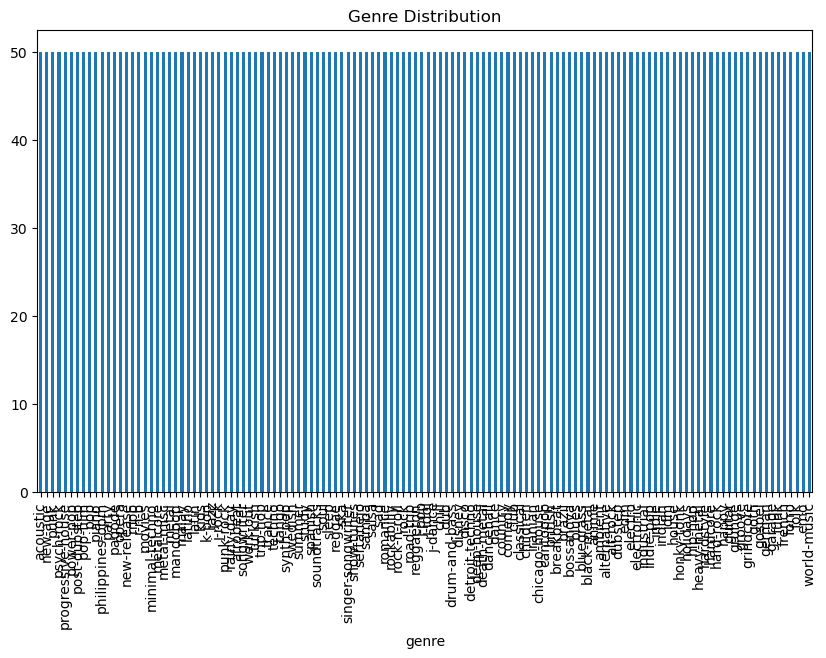

In [2]:
## Feature Engineering
import matplotlib.pyplot as plt
# convert duration to minutes
df['duration_min'] = df['duration_ms'] / 60000

# artist popularity
df['artist_popularity'] = df.groupby('artists')['popularity'].transform('mean')

# drop original columns
df = df.drop(['duration_ms', 'artists'], axis=1)

# Time of day features (if you have timestamp)
#df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# check correlation with target
print(numeric_df.corr()[['explicit']].sort_values('explicit', ascending=False))

# check class balance
plt.figure(figsize=(10, 6))
df[target].value_counts().plot(kind='bar')
plt.title('Genre Distribution')
plt.show()

In [3]:
# Train/Test Split

from sklearn.model_selection import train_test_split

X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [4]:
## Build Pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# define preprocessing
numeric_features = ['duration_min', 'popularity', 'artist_popularity', 'explicit']
categorical_features = []

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=200
    ))
])


                   precision    recall  f1-score   support

         acoustic       0.07      0.10      0.08        10
         afrobeat       0.14      0.20      0.17        10
         alt-rock       0.40      0.40      0.40        10
      alternative       0.00      0.00      0.00        10
          ambient       0.00      0.00      0.00        10
            anime       0.08      0.10      0.09        10
      black-metal       0.14      0.10      0.12        10
        bluegrass       0.08      0.10      0.09        10
            blues       0.00      0.00      0.00        10
        bossanova       0.09      0.10      0.10        10
           brazil       0.14      0.20      0.17        10
        breakbeat       0.08      0.10      0.09        10
          british       0.00      0.00      0.00        10
         cantopop       0.12      0.10      0.11        10
    chicago-house       0.30      0.30      0.30        10
         children       0.12      0.10      0.11       

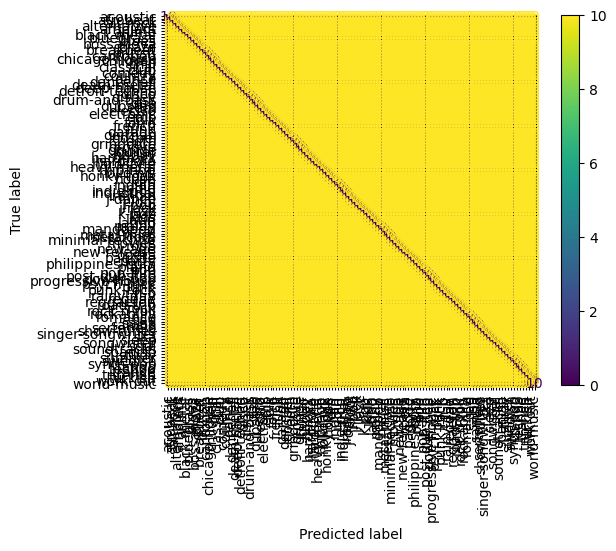

In [5]:
# Train and Evaluate

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# train
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_test, xticks_rotation=90)
plt.show()

In [6]:
## Hyperparameter Tuning 

from sklearn.model_selection import GridSearchCV

# define parameter grid
param_grid = {
    'classifier__max_depth': [10, 30, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# search
grid_search = GridSearchCV(model, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(best_model.score(X_test, y_test))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END classifier__max_depth=10, classifier__min_samples_split=2; total time=   2.7s
[CV] END classifier__max_depth=10, classifier__min_samples_split=2; total time=   2.3s
[CV] END classifier__max_depth=10, classifier__min_samples_split=2; total time=   2.3s
[CV] END classifier__max_depth=10, classifier__min_samples_split=5; total time=   2.5s
[CV] END classifier__max_depth=10, classifier__min_samples_split=5; total time=   2.4s
[CV] END classifier__max_depth=10, classifier__min_samples_split=5; total time=   2.2s
[CV] END classifier__max_depth=10, classifier__min_samples_split=10; total time=   2.1s
[CV] END classifier__max_depth=10, classifier__min_samples_split=10; total time=   2.1s
[CV] END classifier__max_depth=10, classifier__min_samples_split=10; total time=   2.1s
[CV] END classifier__max_depth=30, classifier__min_samples_split=2; total time=   4.6s
[CV] END classifier__max_depth=30, classifier__min_samples_split=2;

In [7]:
## Prediction Function

def predict_genre(duration_min, popularity, explicit, artist_popularity):
    input_data = pd.DataFrame({
        'duration_min': [duration_min],
        'popularity': [popularity],
        'explicit': [int(explicit)],
        'artist_popularity': [artist_popularity]
    })
    return model.predict(input_data)[0]

# Example
print(predict_genre(
    duration_min=3.5,
    popularity=68,
    explicit=True,
    artist_popularity=72
))

party


In [8]:
# saving the model

import joblib

# Save the trained model
model_filename = 'spotify_genre_classifier.joblib'
joblib.dump(model, model_filename)

# Later load it with:
# loaded_model = joblib.load(model_filename)

['spotify_genre_classifier.joblib']